In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, precision_recall_curve, precision_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import QuantileTransformer, LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_predict
from lightgbm import LGBMClassifier
from tqdm import tnrange, tqdm
from scipy.stats import kurtosis, skew
import gc
import argparse
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

/Users/v0h0041/Documents/kaggle/env/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
seed = 11
data_dir = '../input/'
np.random.seed(seed)

In [3]:
def train_model(data_, data_val_, y_, y_val, features, **clf_kwargs):

    oof_preds = np.zeros(data_val_.shape[0])
    n_fold = 0
    
    feature_importance_df = pd.DataFrame()
    
    feats = features
    
    trn_x, trn_y = data_[feats], y_
    val_x, val_y = data_val_[feats], y_val

    clf = LGBMClassifier().set_params(**clf_kwargs)

    clf.fit(trn_x, trn_y, 
            eval_set= [(trn_x, trn_y), (val_x, val_y)], 
            eval_metric='auc', verbose=100, early_stopping_rounds=500  #30
           )

    oof_preds = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds)))
    del trn_x, trn_y, val_x, val_y
    gc.collect()
        
    return oof_preds, feature_importance_df


def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

def display_roc_curve(y_, oof_preds_, folds_idx_):
    # Plot ROC curves
    plt.figure(figsize=(6,6))
    scores = [] 
    for n_fold, (_, val_idx) in enumerate(folds_idx_):  
        # Plot the roc curve
        fpr, tpr, thresholds = roc_curve(y_.iloc[val_idx], oof_preds_[val_idx])
        score = roc_auc_score(y_.iloc[val_idx], oof_preds_[val_idx])
        scores.append(score)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (n_fold + 1, score))
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)
    fpr, tpr, thresholds = roc_curve(y_, oof_preds_)
    score = roc_auc_score(y_, oof_preds_)
    plt.plot(fpr, tpr, color='b',
             label='Avg ROC (AUC = %0.4f $\pm$ %0.4f)' % (score, np.std(scores)),
             lw=2, alpha=.8)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('LightGBM ROC Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    
    plt.savefig('roc_curve.png')

def feature_loader_helper(df_features):
    df_features.fillna(0, inplace=True)
#     for col in df_features.columns:
#         if 'server_date_<lambda_0>' in col:
#             df_features[col] = df_features[col].apply(lambda x: str(x).split()[0]).astype(np.float16)
    return df_features

def load_features(features_dir= '../output/', days_from = [-1], days_to = [-8], weights=[]):
    train_features, val_features, test_features = None, None, None
    feats = []
    for id, (i, j) in enumerate(zip(days_from, days_to)):
        print('Loading {} and {}'.format(i, j))
        if train_features is None:
            train_features = pd.read_csv(os.path.join(features_dir
                                                  , 'train_features_{}_{}.csv'.format(i, j)))
            train_features = feature_loader_helper(train_features)
        else:
            df_features = pd.read_csv(os.path.join(features_dir
                                                  , 'train_features_{}_{}.csv'.format(i, j)))

            df_features = feature_loader_helper(df_features)
            if len(weights) == 0:
                train_features = train_features.join(df_features. \
                                                 set_index('impression_id')
                                                 , on = 'impression_id'
                                                 , how='left'
                                                 , rsuffix = '{}_{}'.format(i, j))
            else:
                if len(feats) == 0:
                    feats = [c for c in train_features.columns if c != 'impression_id']
                train_features[feats] = train_features[feats] + df_features[feats]*weights[id]/weights[0]

        if val_features is None:
            val_features = pd.read_csv(os.path.join(features_dir
                                                  , 'val_features_{}_{}.csv'.format(i, j)))
            
            val_features = feature_loader_helper(val_features)

        else:
            df_features = pd.read_csv(os.path.join(features_dir
                                                  , 'val_features_{}_{}.csv'.format(i, j)))

            df_features = feature_loader_helper(df_features)
            if len(weights) == 0:
                val_features = val_features.join(df_features. \
                                             set_index('impression_id')
                                             , on = 'impression_id'
                                             , how='left'
                                             , rsuffix = '{}_{}'.format(i, j))
            else:
                val_features[feats] = val_features[feats] + df_features[feats]*weights[id]/weights[0]

        if test_features is None:
            test_features = pd.read_csv(os.path.join(features_dir
                                                  , 'test_features_{}_{}.csv'.format(i, j)))

            test_features = feature_loader_helper(test_features)                                    
        else:
            df_features = pd.read_csv(os.path.join(features_dir
                                                  , 'test_features_{}_{}.csv'.format(i, j)))

            df_features = feature_loader_helper(df_features)
            if len(weights) == 0:
                test_features = test_features.join(df_features. \
                                              set_index('impression_id')
                                             , on = 'impression_id'
                                             , how='left'
                                             , rsuffix = '{}_{}'.format(i, j))
            else:
                test_features[feats] = test_features[feats] + df_features[feats]*weights[id]/weights[0]
    
    if len(weights) > 0:
        train_features[feats] = train_features[feats]*weights[0]
        test_features[feats] = test_features[feats]*weights[0]
        val_features[feats] = val_features[feats]*weights[0]

    return train_features, val_features, test_features

In [4]:
df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
df_test = pd.read_csv(os.path.join(data_dir, 'test.csv'))

df_train_count_vect = pd.read_csv('../new_output/svtct_hash_train_0_8.csv')
df_test_count_vect = pd.read_csv('../new_output/svtct_hash_test_0_8.csv')

df_train = df_train.merge(df_train_count_vect, on = 'impression_id',how = 'left')
df_test = df_test.merge(df_test_count_vect, on = 'impression_id',how = 'left')

df_train.fillna(-1,inplace = True)
df_test.fillna(-1,inplace=True)

df_train['impression_time'] = pd.to_datetime(df_train['impression_time'])
df_test['impression_time'] = pd.to_datetime(df_test['impression_time'])

df_train['impression_date'] = df_train['impression_time'].dt.date.astype(str)
df_test['impression_date'] = df_test['impression_time'].dt.date.astype(str)

df_val = df_train.loc[df_train['impression_date'] > '2018-12-05'].reset_index(drop=True)
df_train = df_train.loc[df_train['impression_date'] < '2018-12-06'].reset_index(drop=True)

train_features, val_features, test_features = load_features(features_dir= '../new_output/'
, days_from = [-1,  -8, -15, -22, -1]
, days_to = [-8,  -15, -22, -29, -35]
, weights = [])

df_train = df_train.join(train_features.set_index('impression_id'), on='impression_id', how='left')
df_val = df_val.join(val_features.set_index('impression_id'), on='impression_id', how='left')
df_test = df_test.join(test_features.set_index('impression_id'), on='impression_id', how='left')

Loading -1 and -8
Loading -8 and -15
Loading -15 and -22
Loading -22 and -29
Loading -1 and -35


In [5]:
for col in df_train.columns:
    if 'count' in col:
        df_train[col] = np.log1p(1+df_train[col])
        df_val[col] = np.log1p(1+df_val[col])
        df_test[col] = np.log1p(1+df_test[col])

In [6]:
server_time_max = [c for c in df_train.columns if 'server_time_max' in c]
server_time_max

['server_time_max',
 'server_time_max-8_-15',
 'server_time_max-15_-22',
 'server_time_max-22_-29',
 'server_time_max-1_-35']

In [7]:
for s in server_time_max:
    df_train[s] = pd.to_datetime(df_train[s])
    df_train['days_difference_{}'.format(s)] = (df_train['impression_time'] - df_train[s]).apply(lambda x: x.value/10**12)
    
    df_val[s] = pd.to_datetime(df_val[s])
    df_val['days_difference_{}'.format(s)] = (df_val['impression_time'] - df_val[s]).apply(lambda x: x.value/10**12)
    
    df_test[s] = pd.to_datetime(df_test[s])
    df_test['days_difference_{}'.format(s)] = (df_test['impression_time'] - df_test[s]).apply(lambda x: x.value/10**12)

In [8]:
import numba
from numba import prange
from collections import defaultdict

In [9]:
@numba.jit
def get_splits(a):
    m = np.concatenate([[True], a[1:] != a[:-1], [True]])
    m = np.flatnonzero(m)
    return m


@numba.jit
def get_expanding_count(user, time, col=None):
    '''
    user: user_id
    time: DateTime col (converted to int)
    col: attribute col (product/webpage)
    '''
    out = np.zeros((len(user), ))
    if col is not None:
        col_unq = np.unique(col)
        for col_val in col_unq:
            col_val_idx = np.where(col == col_val)[0]
            col_user = user[col_val_idx]
            col_time = time[col_val_idx]
            col_out = np.zeros((len(col_val_idx), ))
            m = get_splits(col_user)
            n = len(m) -1
            for i in range(n):
                j = m[i]
                k = m[i+1]
                sub_time = col_time[j:k]
                oo = get_splits(sub_time)
                pp = len(oo) - 1
                for ii in range(pp):
                    col_out[j+oo[ii]:j+oo[ii+1]] = oo[ii] + 1
            out[col_val_idx] = col_out[:]
            
    else:
        m = get_splits(user)
        n = len(m) -1
        for i in range(n):
            j = m[i]
            k = m[i+1]
            sub_time = time[j:k]
            oo = get_splits(sub_time)
            pp = len(oo) - 1
            for ii in range(pp):
                out[j+oo[ii]:j+oo[ii+1]] = oo[ii] + 1
    return np.log1p(out)

In [10]:
@numba.jit
def get_prev_view(user, time, col=None):
    '''
    user: user_id
    time: DateTime col (converted to int)
    col: attribute col (product/webpage)
    '''
    out = -1*np.ones((len(user), ))
    if col is not None:
        col_unq = np.unique(col)
        for col_val in col_unq:
            col_val_idx = np.where(col == col_val)[0]
            col_user = user[col_val_idx]
            col_time = time[col_val_idx]
            col_out = -1*np.ones((len(col_val_idx), ))
            m = get_splits(col_user)
            n = len(m) -1
            for i in range(n):
                j = m[i]
                k = m[i+1]
                sub_time = col_time[j:k]
                oo = get_splits(sub_time)
                pp = len(oo) - 1
                if pp == 0:
                    col_out[j] = 0
                else:
                    for ii in range(1, pp):
                        col_out[j+oo[ii]:j+oo[ii+1]] = np.log1p(col_time[j+oo[ii]] - col_time[j+oo[ii-1]])
            out[col_val_idx] = col_out[:]
            
    else:
        m = get_splits(user)
        n = len(m) -1
        for i in range(n):
            j = m[i]
            k = m[i+1]
            sub_time = time[j:k]
            oo = get_splits(sub_time)
            pp = len(oo) - 1
            if pp == 0:
                out[j] = -1
            else:
                for ii in range(1, pp):
                    out[j+oo[ii]:j+oo[ii+1]] = np.log1p(time[j+oo[ii]] - time[j+oo[ii-1]])
    return out



In [11]:
@numba.jit
def get_click_counts(user, time, click, col=None):
    '''
    user: user_id
    time: DateTime col (converted to int)
    click: Click column
    col: col (product/webpage)
    '''
    out = np.zeros((len(user), ))
    if col is not None:
        col_unq = np.unique(col)
        for col_val in col_unq:
            col_val_idx = np.where(col == col_val)[0]
            col_user = user[col_val_idx]
            col_time = time[col_val_idx]
            col_click = click[col_val_idx]
            col_out = np.zeros((len(col_val_idx), ))
            m = get_splits(col_user)
            n = len(m) -1
            for i in range(n):
                cnt = 0
                j = m[i]
                k = m[i+1]
                sub_time = col_time[j:k]
                oo = get_splits(sub_time)
                pp = len(oo) - 1
                for ii in range(pp):
                    col_out[j+oo[ii]:j+oo[ii+1]] = cnt
                    cnt += np.sum(col_click[j+oo[ii]:j+oo[ii+1]])
            out[col_val_idx] = col_out[:]
            
    else:
        m = get_splits(user)
        n = len(m) -1
        for i in range(n):
            cnt = 0
            j = m[i]
            k = m[i+1]
            sub_time = time[j:k]
            oo = get_splits(sub_time)
            pp = len(oo) - 1
            for ii in range(pp):
                out[j+oo[ii]:j+oo[ii+1]] = cnt
                cnt += np.sum(click[j+oo[ii]:j+oo[ii+1]])
    return np.log1p(out)

In [12]:
import pandas as pd
import numpy as np 
from collections import Counter
from sklearn.base import BaseEstimator, TransformerMixin

        
class TargetEncoderWithThresh(BaseEstimator, TransformerMixin):
    """
    A utlity class to help encode categorical variables using different methods.
    
    Inputs:
    cols: (List or str) Can be either a string or list of strings with column names
    targetcol: (str) Target column to encode column/group of columns with
    thresh: (int) Minimum count of grouping to encode (Acts as smoothing). Currently not implemented TODO
    func: (str or callable) Function to be applied on column/ group of columns to encode. 
          If str is provided, it should be a attribute of pandas Series
    cname: (str) Column name for new string
    func_kwargs: (dict) Additional arguments to be passed to function 
    add_to_orig: (bool) Whether to return dataframe with added feature or just the feature as series
    
    Output:
    pandas DataFrame/Series
    
    """
    def __init__(self, cols=None, targetcol=None, cname=None, thresh=0, func=np.mean,  add_to_orig=False,
                 func_kwargs={}, use_prior=False, alpha=0.5):                                                 
        self.cols = cols #Can be either a string or list of strings with column names
        self.targetcol = targetcol #Target column to encode column/group of columns with
        self.thresh = thresh  #Minimum count of grouping to encode (Acts as smoothing)
        self.func = func #Function to be applied on column/ group of columns to encode 
        self.add_to_orig = add_to_orig #Whether return a dataframe with added feature or just a series of feature
        self.cname = cname #Column to new feature generated
        self.func_kwargs = func_kwargs  #Additional key word arguments to be applied to func
        self.alpha = alpha #smoothing factor
        self.use_prior = use_prior
        
    #@numba.jit        
    def fit(self, X, y=None):
            
        if isinstance(self.func, str):
            if hasattr(pd.Series, self.func):
                #print("here")
                vals = getattr(X.groupby(self.cols)[self.targetcol], self.func)
                self.dictmap = vals(**self.func_kwargs)
                prior = getattr(X[self.targetcol], self.func)(**self.func_kwargs)
                
        else:
            self.dictmap = X.groupby(self.cols)[self.targetcol].apply(lambda x: self.func(x, **self.func_kwargs))
            prior = X[[self.targetcol]].apply(lambda x: self.func(x, **self.func_kwargs)).values[0]
        self.counts = Counter(zip(*[X[col].tolist() for col in self.cols]))
        if len(self.cols) == 1:
            counts_greater_than_thresh = [k[0] for k, v in self.counts.items() if v >= self.thresh ]
        else:
            counts_greater_than_thresh = [k for k, v in self.counts.items() if v >= self.thresh ]
        
        #print(self.dictmap.head())
        #print(self.counts.most_common(10))
        self.dictmap = self.dictmap.loc[self.dictmap.index.isin(counts_greater_than_thresh)]
        if self.use_prior:
            self.dictmap = {k: ((self.counts[k] * v + prior * self.alpha)/(self.counts[k] + self.alpha))
                            for k, v in self.dictmap.items()}
            self.dictmap = pd.Series(self.dictmap)
            self.dictmap.index.names = self.cols
        #print(self.dictmap.head())
        
        if self.cname:
            self.dictmap.name = self.cname
        else:
            cname = ''
            cname = [cname + '_' +str(col) for col in self.cols]
            self.cname = '_'.join(cname) + "_" + str(self.func)
            self.dictmap.name = self.cname
            
        #print(self.cname)
        #self.dictmap = self.dictmap
        return self
    
    #@numba.jit
    def transform(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            X_transformed = X[self.cols]
            
            X_transformed = X_transformed.join(self.dictmap, on=self.cols, how='left')[self.cname]

            if self.add_to_orig:
                return pd.concat([X, X_transformed], axis=1, copy=False)
            else:
                return X_transformed.values

        else:
            raise TypeError("Input should be a pandas DataFrame")


In [13]:
@numba.jit
def get_prev_click(user, time, click, col=None):
    '''
    user: user_id
    time: DateTime col (converted to int)
    click: Click column
    col: col (product/webpage)
    '''
    out = -1* np.ones((len(user), ))
    if col is not None:
        col_unq = np.unique(col)
        for col_val in col_unq:
            col_val_idx = np.where(col == col_val)[0]
            col_user = user[col_val_idx]
            col_time = time[col_val_idx]
            col_click = click[col_val_idx]
            col_out = -1 * np.ones((len(col_val_idx), ))
            m = get_splits(col_user)
            n = len(m) -1
            for i in range(n):
                prev_time =-1
                j = m[i]
                k = m[i+1]
                sub_time = col_time[j:k]
                oo = get_splits(sub_time)
                pp = len(oo) - 1
                for ii in range(pp):
                    if prev_time != -1:
                        col_out[j+oo[ii]:j+oo[ii+1]] = np.log1p(col_time[j+oo[ii]] - prev_time)
                    if np.sum(col_click[j+oo[ii]:j+oo[ii+1]]) >= 1:
                        prev_time = col_time[j+oo[ii]] 
            out[col_val_idx] = col_out[:]
            
    else:
        m = get_splits(user)
        n = len(m) -1
        for i in range(n):
            prev_time = -1
            j = m[i]
            k = m[i+1]
            sub_time = time[j:k]
            oo = get_splits(sub_time)
            pp = len(oo) - 1
            for ii in range(pp):
                if prev_time != -1:
                    out[j+oo[ii]:j+oo[ii+1]] = np.log1p(time[j+oo[ii]] - prev_time)
                if np.sum(click[j+oo[ii]:j+oo[ii+1]]) >= 1:
                    prev_time = time[j+oo[ii]]
    return out

In [14]:
def woe(X, y, cont=True):
    try:
        tmp = pd.DataFrame()
        tmp["variable"] = X
        if cont:
            tmp["variable"] = pd.qcut(tmp["variable"], 255, duplicates="drop")
        tmp["target"] = y
        var_counts = tmp.groupby("variable")["target"].count()
        var_events = tmp.groupby("variable")["target"].sum()
        var_nonevents = var_counts - var_events
        tmp["var_counts"] = tmp.variable.map(var_counts)
        tmp["var_events"] = tmp.variable.map(var_events)
        tmp["var_nonevents"] = tmp.variable.map(var_nonevents)
        events = sum(tmp["target"] == 1)
        nonevents = sum(tmp["target"] == 0)
        div_series = (tmp["var_nonevents"].astype(float)/nonevents).divide(tmp["var_events"].astype(float)/events)
        tmp["woe"] = np.log(div_series)
        tmp["woe"] = tmp["woe"].replace(np.inf, 0).replace(-np.inf, 0)
        tmp["iv"] = (tmp["var_nonevents"].astype(float)/nonevents - \
                     tmp["var_events"].astype(float)/events) * tmp["woe"].astype(float)
        iv = tmp.groupby("variable")["iv"].last().sum()
        return tmp["woe"], tmp["iv"], iv
    except:
        return 0

In [15]:
df_train.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,count_vector_sum,count_vector_sum_mean,count_vector_len,...,category_1_13_sum-1_-35,category_1_14_sum-1_-35,category_1_15_sum-1_-35,category_1_16_sum-1_-35,category_1_17_sum-1_-35,days_difference_server_time_max,days_difference_server_time_max-8_-15,days_difference_server_time_max-15_-22,days_difference_server_time_max-22_-29,days_difference_server_time_max-1_-35
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,-9.223372e+06,-9.223372e+06,-9.223372e+06,-9.223372e+06,-9.223372e+06
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,-9.223372e+06,-9.223372e+06,-9.223372e+06,-9.223372e+06,-9.223372e+06
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,-9.223372e+06,-9.223372e+06,-9.223372e+06,-9.223372e+06,-9.223372e+06
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0,0.055434,0.693147,3.713572,...,0.0,0.0,0.0,0.0,0.0,1.738200e+02,-9.223372e+06,-9.223372e+06,-9.223372e+06,1.738200e+02
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0,-1.301468,0.693146,3.912023,...,0.0,0.0,0.0,0.0,0.0,1.869600e+02,-9.223372e+06,-9.223372e+06,2.045760e+03,1.869600e+02


In [16]:
def get_view_feats(df):
    df = df.copy()
    users = df["user_id"].values
    times = df["impression_time"].astype(int).values/10**12
    app_code = df["app_code"].values
    os_version = df["os_version"].values
    is_4G = df["is_4G"].values
    df["prev_view"] = get_prev_view(users, times)
    
    df["prev_app_view"] = get_prev_view(users, times, app_code)
    df["prev_os_view"] = get_prev_view(users, times, os_version)
    
    df["prev_4G_view"] = get_prev_view(users, times, is_4G)
    return df

In [17]:
def get_count_feats(df):
    df = df.copy()
    users = df["user_id"].values
    times = df["impression_time"].astype(int).values/10**12
    app_code = df["app_code"].values
    os_version = df["os_version"].values
    is_4G = df["is_4G"].values
    
    df["view_counts"] = get_expanding_count(users, times)
    df["user_app_counts"] = get_expanding_count(users, times, app_code)
    df["user_os_counts"] = get_expanding_count(users, times, os_version)
    df["user_4g_counts"] = get_expanding_count(users, times, is_4G)

    return df


In [18]:
def get_click_feats(tr, val):
    tr = tr.copy()
    uids = tr["user_id"].values
    app_code = tr["app_code"].values
    os_version = tr["os_version"].values
    datetime = tr["impression_time"].astype(int).values/10**12
    clicks = tr["is_click"].values
    
    tr["prev_click"] = get_prev_click(uids, datetime, clicks)
    tr["prev_app_click"] = get_prev_click(uids, datetime, clicks, app_code)
    tr["prev_os_click"] = get_prev_click(uids, datetime, clicks, os_version)
    
    tr["click_counts"] = get_click_counts(uids, datetime, clicks)
    tr["app_click_counts"] = get_click_counts(uids, datetime, clicks, app_code)
    tr["os_click_counts"] = get_click_counts(uids, datetime, clicks, os_version)
    
    tr_clicks = tr.loc[tr.is_click == 1].groupby("user_id")["impression_time"].max()
    val["prev_click_time"] = val.user_id.map(tr_clicks)
    val["prev_click"] = np.log1p((val["impression_time"] - val["prev_click_time"]).astype(int)/10**12)
    val["prev_click"] = val["prev_click"].fillna(-1)
    del val["prev_click_time"]
    
    tr_clicks = tr.loc[tr.is_click == 1].groupby(["user_id", "app_code"])["impression_time"].max()
    tr_clicks.name = "prev_app_click_time"
    val = val.join(tr_clicks, on=["user_id", "app_code"], how="left")
    val["prev_app_click"] = np.log1p((val["impression_time"] - val["prev_app_click_time"]).astype(int)/10**12)
    val["prev_app_click"] = val["prev_app_click"].fillna(-1)
    del val["prev_app_click_time"]
                   
    tr_clicks = tr.loc[tr.is_click == 1].groupby(["user_id", "os_version"])["impression_time"].max()
    tr_clicks.name = "prev_os_click_time"
    val = val.join(tr_clicks, on=["user_id", "os_version"], how="left")
    val["prev_os_click"] = np.log1p((val["impression_time"] - val["prev_os_click_time"]).astype(int)/10**12)
    val["prev_os_click"] = val["prev_os_click"].fillna(-1)
    del val["prev_os_click_time"]
    
    val["click_counts"] = val["user_id"].map(np.log1p(tr.groupby("user_id")["is_click"].sum())).fillna(0)
    
    tmp = np.log1p(tr.groupby(["user_id", "app_code"])["is_click"].sum())
    tmp.name = "app_click_counts"
    val = val.join(tmp, on=["user_id", "app_code"], how="left").fillna(0)
    
    tmp = np.log1p(tr.groupby(["user_id", "os_version"])["is_click"].sum())
    tmp.name = "os_click_counts"
    val = val.join(tmp, on=["user_id", "os_version"], how="left").fillna(0)
    
    
    return tr, val

In [19]:
df_train['flag1'] = 'train'
df_val['flag1'] = 'val'
df_test['flag1'] = 'test'

df_test['is_click'] = 0

df_data_all = pd.concat([df_train, df_val, df_test], axis = 0)

In [20]:
df_data_all['number_of_uq_items_per_session'] = df_data_all['item_id_nunique'].divide(df_data_all['session_id_nunique'])

In [21]:
df_train.sort_values(by=["user_id", "impression_time"], inplace=True)
df_data_all.sort_values(by=["user_id", "impression_time"], inplace=True)

In [22]:
df_train = get_view_feats(df_train)
df_data_all = get_view_feats(df_data_all)

In [23]:
df_train = get_count_feats(df_train)
df_data_all = get_count_feats(df_data_all)

In [24]:
df_train["hour"] = df_train["impression_time"].dt.hour
df_train["dayofweek"] = df_train["impression_time"].dt.dayofweek

df_data_all["hour"] = df_data_all["impression_time"].dt.hour
df_data_all["dayofweek"] = df_data_all["impression_time"].dt.dayofweek

In [25]:
def get_overall_count_feats(df):
    df = df.copy()
    enc = TargetEncoderWithThresh(cols=["user_id"], targetcol="is_click", func='count')
    df["all_counts"] = np.log1p(enc.fit_transform(df))
    
    enc = TargetEncoderWithThresh(cols=["app_code"], targetcol="is_click", func='count')
    df["app_counts"] = np.log1p(enc.fit_transform(df))

    enc = TargetEncoderWithThresh(cols=["os_version"], targetcol="is_click", func='count')
    df["os_counts"] = np.log1p(enc.fit_transform(df))

    enc = TargetEncoderWithThresh(cols=["user_id", "app_code"], targetcol="is_click", func='count')
    df["all_usr_app_counts"] = np.log1p(enc.fit_transform(df))

    enc = TargetEncoderWithThresh(cols=["user_id", "os_version"], targetcol="is_click", func='count')
    df["all_usr_os_counts"] = np.log1p(enc.fit_transform(df))

    enc = TargetEncoderWithThresh(cols=["user_id", "app_code", "os_version"], targetcol="is_click", func='count')
    df["all_usr_app_os_counts"] = np.log1p(enc.fit_transform(df))
    
    enc = TargetEncoderWithThresh(cols=["user_id", "app_code", "os_version", 'impression_date'], targetcol="is_click", func='count')
    df["all_usr_app_os_date_counts"] = np.log1p(enc.fit_transform(df))
    
    enc = TargetEncoderWithThresh(cols=["user_id", "hour"], targetcol="is_click", func='count')
    df["usr_hour_counts"] = np.log1p(enc.fit_transform(df))

    enc = TargetEncoderWithThresh(cols=["user_id", "impression_date"], targetcol="is_click", func='count')
    df["usr_date_counts"] = np.log1p(enc.fit_transform(df))

    enc = TargetEncoderWithThresh(cols=["user_id", "app_code", "impression_date"], targetcol="is_click", func='count')
    df["usr_app_date_counts"] = np.log1p(enc.fit_transform(df))
    
    enc = TargetEncoderWithThresh(cols=["user_id"], targetcol="app_code", func='nunique')
    df["usr_nunq_app"] = enc.fit_transform(df)
    
    enc = TargetEncoderWithThresh(cols=["user_id", "impression_date"], targetcol="app_code", func='nunique')
    df["usr_date_nunq_app"] = enc.fit_transform(df)
    return df

In [26]:
df_train.columns

Index(['impression_id', 'impression_time', 'user_id', 'app_code', 'os_version',
       'is_4G', 'is_click', 'count_vector_sum', 'count_vector_sum_mean',
       'count_vector_len',
       ...
       'prev_view', 'prev_app_view', 'prev_os_view', 'prev_4G_view',
       'view_counts', 'user_app_counts', 'user_os_counts', 'user_4g_counts',
       'hour', 'dayofweek'],
      dtype='object', length=222)

In [27]:
df_train = get_overall_count_feats(df_train)
df_data_all = get_overall_count_feats(df_data_all)

In [28]:
import math
def entropy2(labels, base=None):
    """ Computes entropy of label distribution. """

    n_labels = len(labels)

    if n_labels <= 1:
        return 0

    value,counts = np.unique(labels, return_counts=True)
    probs = counts / n_labels
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0

    ent = 0.

    # Compute entropy
    base = math.e if base is None else base
    for i in probs:
        ent -= i * math.log(i, base)

    return ent

In [29]:
def get_target_encoding(tr, val, y_tr):
    cvlist2 = list(StratifiedKFold(10, shuffle=True, random_state=12345786).split(tr, y_tr))
    
    print("Likelihhod encoding app_code user_id")
    enc = TargetEncoderWithThresh(cols=["user_id", "app_code"], targetcol="is_click", use_prior=True, func='mean')
    tr["user_app_tmean"] = cross_val_predict(enc, tr, y_tr, cv=cvlist2, method="transform", n_jobs=-1)
    val["user_app_tmean"] = enc.fit(tr).transform(val)
    val["user_app_tmean"].fillna(tr['is_click'].mean())

    print("Likelihhod encoding user_id hour")
    enc = TargetEncoderWithThresh(cols=["user_id", "hour"], targetcol="is_click", use_prior=True, func='mean')
    tr["user_hour_tmean"] = cross_val_predict(enc, tr, y_tr, cv=cvlist2, method="transform", n_jobs=-1)
    val["user_hour_tmean"] = enc.fit(tr).transform(val)
    val["user_hour_tmean"].fillna(tr['is_click'].mean())

    print("Likelihhod encoding user_id dow")
    enc = TargetEncoderWithThresh(cols=["user_id", "dayofweek"], targetcol="is_click", use_prior=True, func='mean')
    tr["user_dow_tmean"] = cross_val_predict(enc, tr, y_tr, cv=cvlist2, method="transform", n_jobs=-1)
    val["user_dow_tmean"] = enc.fit(tr).transform(val)
    val["user_dow_tmean"].fillna(tr['is_click'].mean())
    
    print("Likelihhod encoding user_id os_version")
    enc = TargetEncoderWithThresh(cols=["user_id", "os_version"], targetcol="is_click", use_prior=True, func='mean')
    tr["user_os_tmean"] = cross_val_predict(enc, tr, y_tr, cv=cvlist2, method="transform", n_jobs=-1)
    val["user_os_tmean"] = enc.fit(tr).transform(val)
    val["user_os_tmean"].fillna(tr['is_click'].mean())
    
    print("Likelihhod encoding app_code user_id os_version")
    enc = TargetEncoderWithThresh(cols=["user_id", "app_code", 'os_version'], targetcol="is_click", use_prior=True, func='mean')
    tr["user_app_os_tmean"] = cross_val_predict(enc, tr, y_tr, cv=cvlist2, method="transform", n_jobs=-1)
    val["user_app_os_tmean"] = enc.fit(tr).transform(val)
    val["user_app_os_tmean"].fillna(tr['is_click'].mean())
    
    print("Likelihhod encoding os_version app_os_entropy")
    enc = TargetEncoderWithThresh(cols=["app_code", "os_version"], targetcol="user_id", use_prior=True, func=entropy2)
    tr["app_os_entropy"] = cross_val_predict(enc, tr, y_tr, cv=cvlist2, method="transform", n_jobs=-1)
    val["app_os_entropy"] = enc.fit(tr).transform(val)
    
    print("Likelihhod encoding app_entropy")
    enc = TargetEncoderWithThresh(cols=["app_code"], targetcol="user_id", use_prior=True, func=entropy2)
    tr["app_entropy"] = cross_val_predict(enc, tr, y_tr, cv=cvlist2, method="transform", n_jobs=-1)
    val["app_entropy"] = enc.fit(tr).transform(val)

    print("Likelihhod encoding app_hour_entropy")
    enc = TargetEncoderWithThresh(cols=["app_code", 'hour'], targetcol="user_id", use_prior=True, func=entropy2)
    tr["app_hour_entropy"] = cross_val_predict(enc, tr, y_tr, cv=cvlist2, method="transform", n_jobs=-1)
    val["app_hour_entropy"] = enc.fit(tr).transform(val)

    print("Likelihhod encoding user id")
    enc = TargetEncoderWithThresh(cols=["user_id"], targetcol="is_click", use_prior=True, func='mean', alpha=5)
    tr["usr_tmean"] = cross_val_predict(enc, tr, y_tr, cv=cvlist2, method="transform", n_jobs=-1)
    val["usr_tmean"] = enc.fit(tr).transform(val)
    val["usr_tmean"].fillna(tr['is_click'].mean())
    
    print("Likelihhod encoding app_code")
    enc = TargetEncoderWithThresh(cols=["app_code"], targetcol="is_click", use_prior=True, func='mean', alpha=5)
    tr["app_tmean"] = cross_val_predict(enc, tr, y_tr, cv=cvlist2, method="transform", n_jobs=-1)
    val["app_tmean"] = enc.fit(tr).transform(val)
    val["app_tmean"].fillna(tr['is_click'].mean())
    
    return tr, val

In [30]:
def load_factorizations(df):
    df = df.join(pd.read_csv('../new_output/X_user_category_2_tsvd_5factors.csv').set_index('user_id'),
                on = 'user_id', how='left')
    
    df = df.join(pd.read_csv('../new_output/X_user_category_2_nmf_5factors.csv').set_index('user_id'),
                on = 'user_id', how='left')
    
    df = df.join(pd.read_csv('../new_output/X_user_category_3_nmf_5factors.csv').set_index('user_id'),
                on = 'user_id', how='left')
    
    df = df.join(pd.read_csv('../new_output/X_user_category_3_tsvd_5factors.csv').set_index('user_id'),
                on = 'user_id', how='left')
    
    df = df.join(pd.read_csv('../new_output/X_user_category_1_nmf_5factors.csv').set_index('user_id'),
                on = 'user_id', how='left')
    
    df = df.join(pd.read_csv('../new_output/X_user_category_1_tsvd_5factors.csv').set_index('user_id'),
                on = 'user_id', how='left')
    
    df = df.join(pd.read_csv('../new_output/X_user_product_nmf_5factors.csv').set_index('user_id'),
                on = 'user_id', how='left')
    
    df = df.join(pd.read_csv('../new_output/X_user_product_tsvd_5factors.csv').set_index('user_id'),
                on = 'user_id', how='left')
    
    
    df = df.join(pd.read_csv('../new_output/user_id_app_FM.csv.gz', compression='gzip').set_index(['user_id'
                                                                                                  , 'app_code'])
                , on = ['user_id', 'app_code'], how = 'left')
    df.drop(columns=['num'], inplace=True)
    df = df.join(pd.read_csv('../new_output/usr_os_app_fm.csv.gz', compression='gzip').set_index(['user_id'
                                                                                                  , 'os_version'
                                                                                                  , 'app_code'])
                , on = ['user_id', 'os_version','app_code'], how = 'left', rsuffix='_uoa')
    df.drop(columns=['num'], inplace=True)
    df['dow'] = pd.to_datetime(df['impression_time']).dt.dayofweek
    
    df = df.join(pd.read_csv('../new_output/usr_dow_app_fm.csv.gz', compression='gzip').set_index(['user_id'
                                                                                                   , 'dow'
                                                                                                  , 'app_code'])
                , on = ['user_id', 'dow','app_code'], how = 'left', rsuffix = '_uda')
    df.drop(columns=['num'], inplace=True)
    return df

In [31]:
df_data_all = load_factorizations(df_data_all)

In [32]:
df_train = df_data_all.loc[df_data_all['flag1'] == 'train']
df_val = df_data_all.loc[df_data_all['flag1'] == 'val']
df_test = df_data_all.loc[df_data_all['flag1'] == 'test']
df_train, df_val = get_target_encoding(df_train, df_val, df_train['is_click'])

Likelihhod encoding app_code user_id
Likelihhod encoding user_id hour
Likelihhod encoding user_id dow
Likelihhod encoding user_id os_version
Likelihhod encoding app_code user_id os_version
Likelihhod encoding os_version app_os_entropy
Likelihhod encoding app_entropy
Likelihhod encoding app_hour_entropy
Likelihhod encoding user id
Likelihhod encoding app_code


In [33]:
df_train, df_val = get_click_feats(df_train, df_val)

In [34]:
df_train_tfid_vect = pd.read_csv('../new_output/svtct_tfidf_train_0_8.csv')
df_test_tfid_vect = pd.read_csv('../new_output/svtct_tfidf_test_0_8.csv')

df_train_count_vect = pd.read_csv('../new_output/svtct_countvectoriser_train_0_8.csv')
df_test_count_vect = pd.read_csv('../new_output/svtct_countvectoriser_test_0_8.csv')


In [35]:
df_train = df_train.merge(df_train_tfid_vect, on ='impression_id', how = 'left')
df_train = df_train.merge(df_train_count_vect, on ='impression_id', how = 'left')

df_val = df_val.merge(df_train_tfid_vect, on ='impression_id', how = 'left')
df_val = df_val.merge(df_train_count_vect, on ='impression_id', how = 'left')

df_test = df_test.merge(df_test_tfid_vect, on ='impression_id', how = 'left')
df_test = df_test.merge(df_test_count_vect, on ='impression_id', how = 'left')



In [51]:
df_val.shape

(48433, 342)

In [53]:
[col for col in df_train.columns if col not in df_test.columns]

['user_app_tmean',
 'user_hour_tmean',
 'user_dow_tmean',
 'user_os_tmean',
 'user_app_os_tmean',
 'app_os_entropy',
 'app_entropy',
 'app_hour_entropy',
 'usr_tmean',
 'app_tmean',
 'prev_click',
 'prev_app_click',
 'prev_os_click',
 'click_counts',
 'app_click_counts',
 'os_click_counts']

In [36]:
feats = df_train.columns[8:]
to_exclude_columns = []
for f in feats:
    try:
        _, _, iv = woe(df_train[f].fillna(0), df_train["is_click"])
    except:
        iv = 0
    if iv < 0.005:
        to_exclude_columns.append(f)
        print(f"IV value for {f} is {iv} - DISCARD THIS")
        print("------")
    else:
        print(f"=====IV value for {f} is {iv}=====")
        print("------")
        
print(len(feats))
feats = [f for f in feats if f not in set(to_exclude_columns + ['impression_time', 'user_id'])]
len(feats)

=====IV value for category_1_0_sum-1_-35 is 0.017658647253205387=====
------
IV value for category_1_0_sum-22_-29 is 0.0021365405001516815 - DISCARD THIS
------
=====IV value for category_1_0_sum-8_-15 is 0.006477380458433336=====
------
=====IV value for category_1_10_sum is 0.008909873348474756=====
------
=====IV value for category_1_10_sum-15_-22 is 0.007139065568379204=====
------
=====IV value for category_1_10_sum-1_-35 is 0.01794623561115999=====
------
=====IV value for category_1_10_sum-22_-29 is 0.006167597549884619=====
------
IV value for category_1_10_sum-8_-15 is 0.004342307161969332 - DISCARD THIS
------
=====IV value for category_1_11_sum is 0.02031080726395933=====
------
=====IV value for category_1_11_sum-15_-22 is 0.00933101500883507=====
------
=====IV value for category_1_11_sum-1_-35 is 0.02255019626224379=====
------
=====IV value for category_1_11_sum-22_-29 is 0.006192096087157077=====
------
IV value for category_1_11_sum-8_-15 is 0.0031102892898985345 - DIS

=====IV value for days_difference_server_time_max-1_-35 is 0.05758881173351069=====
------
=====IV value for days_difference_server_time_max-22_-29 is 0.030408914124521815=====
------
=====IV value for days_difference_server_time_max-8_-15 is 0.031512050344702995=====
------
IV value for flag1 is 0 - DISCARD THIS
------
IV value for impression_date is 0 - DISCARD THIS
------
IV value for impression_id is 0 - DISCARD THIS
------
=====IV value for impression_time is 0.03885809932928582=====
------
IV value for is_4G is 0.0 - DISCARD THIS
------
IV value for is_click is 0.0 - DISCARD THIS
------
=====IV value for item_id_count is 0.06486896451170578=====
------
=====IV value for item_id_count-15_-22 is 0.024951321436909042=====
------
=====IV value for item_id_count-1_-35 is 0.05263970904980381=====
------
=====IV value for item_id_count-22_-29 is 0.022380386057903646=====
------
=====IV value for item_id_count-8_-15 is 0.023118427031221623=====
------
=====IV value for item_id_nunique is

=====IV value for all_usr_app_os_date_counts is 0.0056782298784970545=====
------
IV value for usr_hour_counts is 0.003829578489807774 - DISCARD THIS
------
=====IV value for usr_date_counts is 0.005212971816439901=====
------
=====IV value for usr_app_date_counts is 0.0056782298784970545=====
------
=====IV value for usr_nunq_app is 0.007267550900318187=====
------
IV value for usr_date_nunq_app is 1.2652750031531947e-05 - DISCARD THIS
------
IV value for category_2_svd1 is 0 - DISCARD THIS
------
=====IV value for category_2_svd2 is 0.08423581911692661=====
------
=====IV value for category_2_svd3 is 0.07459972281871777=====
------
=====IV value for category_2_svd4 is 0.07905670223663966=====
------
=====IV value for category_2_svd5 is 0.07216035786985678=====
------
=====IV value for category_2_nmf1 is 0.11341334287688853=====
------
=====IV value for category_2_nmf2 is 0.08230698848294267=====
------
=====IV value for category_2_nmf3 is 0.07182102115968472=====
------
=====IV value

276

In [37]:
# feats = [f for f in feats if f not in ['svdt_countvect_0','svdt_countvect_1','count_vector_sum','count_vector_sum_mean',
#                                       'count_vector_len']]

In [40]:
X_tr, X_val = df_train[feats], df_val[feats]
#means = X_tr.fillna(-999)
X_tr = X_tr.fillna(-1)
X_val = X_val.fillna(-1)

In [41]:
lgb_params = {
    "n_estimators": 5000,
    "learning_rate": 0.02,
    "num_leaves": 9,
#    'max_depth': 5,
    "min_child_samples": 10,
    "subsample": 0.5,
    "colsample_bytree": 0.125,
    "reg_lambda": 1,
    "reg_alpha": 1,
    "seed":1
}

X_tr, X_val = df_train[feats], df_val[feats]
#means = X_tr.fillna(-999)
X_tr = X_tr.fillna(-1)
X_val = X_val.fillna(-1)

oof_preds, importances = train_model(X_tr, X_val, df_train['is_click'], df_val['is_click'], feats, **lgb_params)

KeyboardInterrupt: 

In [56]:
2618*1.33

3481.94

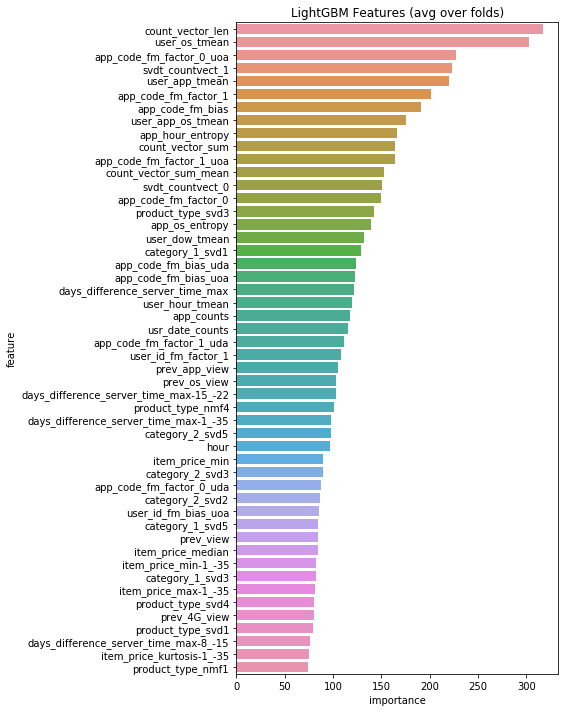

In [39]:
display_importances(importances)

In [46]:
importances.sort_values('importance')

,feature,importance,fold
25,category_1_16_sum,4,1
44,category_1_7_sum-8_-15,6,1
11,category_1_12_sum-15_-22,6,1
132,server_date_nunique-15_-22,8,1
3,category_1_10_sum-15_-22,8,1
135,server_date_nunique-8_-15,8,1
131,server_date_nunique,9,1
176,all_usr_app_os_date_counts,9,1
18,category_1_13_sum-8_-15,10,1
134,server_date_nunique-22_-29,11,1


In [54]:
from scipy.stats import gmean
def get_test_preds(df, feats, flag = 0):
    if flag:
        train = df.loc[df['flag1'].isin(['train', 'val'])].reset_index()
        train = train.loc[train['impression_time'] >= '2018-11-22'].reset_index()
        test = df.loc[df['flag1'] == 'test'].reset_index()
    else:
        train = df.loc[df['flag1'].isin(['train', 'val'])].reset_index()
        test = df.loc[df['flag1'] == 'test'].reset_index()
    print(train.shape, test.shape)
    y_tr = train["is_click"].values
    
    train, test = get_click_feats(train, test)
    train, test = get_target_encoding(train, test, y_tr)
#     train = get_ratio_feats(train)
#     test = get_ratio_feats(test)
    
        
    X_tr, X_test = train[feats], test[feats]
    X_tr = X_tr.fillna(-1)
    X_test = X_test.fillna(-1)
    
    test_preds = []
    for seed in [4,5,1]:
        lgb_params = {
        "n_estimators": 3500,
        "learning_rate": 0.02,
        "num_leaves": 9,
    #    'max_depth': 5,
        "min_child_samples": 10,
        "subsample": 0.5,
        "colsample_bytree": 0.125,
        "reg_lambda": 1,
        "reg_alpha": 1,
        "seed":seed
    }


        model = LGBMClassifier(**lgb_params)
        if flag:
            model.set_params(**{'n_estimators': 1450})
        model.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr)], eval_metric='auc', verbose=50)
        test_preds.append(model.predict_proba(X_test)[:, 1])
    test_preds = gmean(test_preds, axis=0)
    return model, test_preds

In [43]:
df_train.shape

(189176, 342)

In [44]:
df_val.shape

(48433, 342)

In [45]:
df_test.shape

(90675, 326)

In [55]:
all_common_feats = [col for col in df_train.columns if col in df_test.columns]

In [56]:
df_data_all = pd.concat([df_train[all_common_feats],df_val[all_common_feats],df_test[all_common_feats]],axis =0)

In [57]:
_, test_preds1 = get_test_preds(df_data_all, feats)
#_, test_preds2 = get_test_preds(df_data_all, feats, flag=1)

(237609, 327) (90675, 327)
Likelihhod encoding app_code user_id
Likelihhod encoding user_id hour
Likelihhod encoding user_id dow
Likelihhod encoding user_id os_version
Likelihhod encoding app_code user_id os_version
Likelihhod encoding os_version app_os_entropy
Likelihhod encoding app_entropy
Likelihhod encoding app_hour_entropy
Likelihhod encoding user id
Likelihhod encoding app_code
[50]	training's binary_logloss: 0.172682	training's auc: 0.750205
[100]	training's binary_logloss: 0.168768	training's auc: 0.757317
[150]	training's binary_logloss: 0.16656	training's auc: 0.763117
[200]	training's binary_logloss: 0.165331	training's auc: 0.76695
[250]	training's binary_logloss: 0.164424	training's auc: 0.770137
[300]	training's binary_logloss: 0.163791	training's auc: 0.772678
[350]	training's binary_logloss: 0.163223	training's auc: 0.774986
[400]	training's binary_logloss: 0.162753	training's auc: 0.776979
[450]	training's binary_logloss: 0.162304	training's auc: 0.779089
[500]	traini

[2350]	training's binary_logloss: 0.151446	training's auc: 0.826154
[2400]	training's binary_logloss: 0.151212	training's auc: 0.827085
[2450]	training's binary_logloss: 0.150978	training's auc: 0.828021
[2500]	training's binary_logloss: 0.15075	training's auc: 0.828955
[2550]	training's binary_logloss: 0.150507	training's auc: 0.829901
[2600]	training's binary_logloss: 0.150261	training's auc: 0.830848
[2650]	training's binary_logloss: 0.150023	training's auc: 0.831785
[2700]	training's binary_logloss: 0.149793	training's auc: 0.832749
[2750]	training's binary_logloss: 0.149563	training's auc: 0.833637
[2800]	training's binary_logloss: 0.149325	training's auc: 0.834555
[2850]	training's binary_logloss: 0.149085	training's auc: 0.835512
[2900]	training's binary_logloss: 0.148862	training's auc: 0.836384
[2950]	training's binary_logloss: 0.148635	training's auc: 0.837264
[3000]	training's binary_logloss: 0.14841	training's auc: 0.838145
[3050]	training's binary_logloss: 0.148195	trainin

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

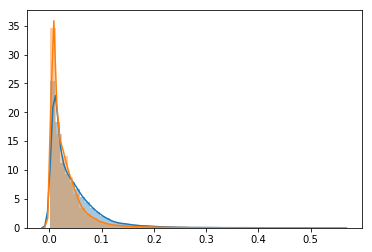

In [46]:
plt.figure()
sns.distplot(oof_preds)
sns.distplot(test_preds1)
#sns.distplot(test_preds2)
plt.show()

In [47]:
df_sub = df_test[['impression_id']]
df_sub['is_click'] = test_preds1#*0.5 + test_preds2*0.5
df_sub.head()

,impression_id,is_click
5290,ccf6d380a63293580f2247d840fca638,0.009676
46094,2a1b2179f709dc95fb4d819a8f3eb80d,0.006589
44940,159e11927eab144e1d24e3255978f111,0.006279
18646,e5e233880ea8d2a06943790dc3d37463,0.013749
38746,c80ea471e47bbbd551543ca8c0e102ea,0.022823


In [48]:
df_sub.to_csv('../submissions/9_hash.csv', index=False)